# 0. Install Dependencies

In [1]:
# !pip install tensorflow==2.3.1 gym keras-rl2 gym[atari]

You should consider upgrading via the 'python -m pip install --upgrade pip' command.


# 1. Test Random Environment with OpenAI Gym

In [1]:
import gym 
import random

In [2]:
import atari_py
!python -m atari_py.import_roms ROMS
print(atari_py.list_games())

copying space_invaders.bin from ROMS\Space Invaders (1980) (Atari, Richard Maurer - Sears) (CX2632 - 49-75153) ~.bin to C:\Program Files\Python37\lib\site-packages\atari_py\atari_roms\space_invaders.bin
['space_invaders', 'tetris']


Traceback (most recent call last):
  File "C:\Program Files\Python37\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Program Files\Python37\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Program Files\Python37\lib\site-packages\atari_py\import_roms.py", line 93, in <module>
    main()
  File "C:\Program Files\Python37\lib\site-packages\atari_py\import_roms.py", line 89, in main
    import_roms(args.dirpath)
  File "C:\Program Files\Python37\lib\site-packages\atari_py\import_roms.py", line 82, in import_roms
    save_if_matches(f)
  File "C:\Program Files\Python37\lib\site-packages\atari_py\import_roms.py", line 68, in save_if_matches
    with open(rom_path, "wb") as out_f:
PermissionError: [Errno 13] Permission denied: 'C:\\Program Files\\Python37\\lib\\site-packages\\atari_py\\atari_roms\\space_invaders.bin'


In [3]:
env = gym.make('SpaceInvaders-v0')
height, width, channels = env.observation_space.shape
actions = env.action_space.n

In [4]:
env.unwrapped.get_action_meanings()

['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']

# 2. Create a Deep Learning Model with Keras

In [5]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Convolution2D
from tensorflow.keras.optimizers import Adam

In [6]:
def build_model(height, width, channels, actions):
    model = Sequential()
    model.add(Convolution2D(32, (8,8), strides=(4,4), activation='relu', input_shape=(3,height, width, channels)))
    model.add(Convolution2D(64, (4,4), strides=(2,2), activation='relu'))
    model.add(Convolution2D(64, (3,3), activation='relu'))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(actions, activation='linear'))
    return model

In [14]:
del model

In [15]:
model = build_model(height, width, channels, actions)

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 3, 51, 39, 32)     6176      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 24, 18, 64)     32832     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 3, 22, 16, 64)     36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 67584)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               34603520  
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_6 (Dense)              (None, 6)                

# 3. Build Agent with Keras-RL and testing

In [17]:
from rl.agents import DQNAgent
from rl.memory import SequentialMemory
from rl.policy import LinearAnnealedPolicy, EpsGreedyQPolicy

In [18]:
def build_agent(model, actions):
    policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=1., value_min=.1, value_test=.2, nb_steps=10000)
    memory = SequentialMemory(limit=1000, window_length=3)
    dqn = DQNAgent(model=model, memory=memory, policy=policy,
                  enable_dueling_network=True, dueling_type='avg', 
                   nb_actions=actions, nb_steps_warmup=1000
                  )
    return dqn

In [19]:
dqn = build_agent(model, actions)
dqn.compile(Adam(lr=1e-4))

In [20]:
pre_trained_model = 'SavedWeights/1m/dqn_weights.h5f'
# Release either one of below to load pre-trained model or to train a new model.
# Load pre-trained model
dqn.load_weights(pre_trained_model)
# Train model
# dqn.fit(env, nb_steps=50000, visualize=False, verbose=2)

In [21]:
# run below test after trained or loaded the model
episode = 20
scores = dqn.test(env, nb_episodes = episode, visualize=False)
print(np.mean(scores.history['episode_reward']))

W0529 14:17:35.858900 15080 deprecation.py:323] From c:\program files\python37\lib\site-packages\tensorflow\python\keras\engine\training_v1.py:2070: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Testing for 20 episodes ...
Episode 1: reward: 325.000, steps: 784
Episode 2: reward: 275.000, steps: 823
Episode 3: reward: 430.000, steps: 859
Episode 4: reward: 390.000, steps: 1176
Episode 5: reward: 440.000, steps: 1033
Episode 6: reward: 170.000, steps: 709
Episode 7: reward: 760.000, steps: 1504
Episode 8: reward: 160.000, steps: 858
Episode 9: reward: 405.000, steps: 1257
Episode 10: reward: 275.000, steps: 1151
Episode 11: reward: 590.000, steps: 1535
Episode 12: reward: 145.000, steps: 649
Episode 13: reward: 230.000, steps: 657
Episode 14: reward: 145.000, steps: 871
Episode 15: reward: 190.000, steps: 626
Episode 16: reward: 235.000, steps: 1123
Episode 17: reward: 155.000, steps: 625
Episode 18: reward: 155.000, steps: 673
Episode 19: reward: 455.000, steps: 1224
Episode 20: reward: 605.000, steps: 1188
326.75


# 4. Plot trained model performance

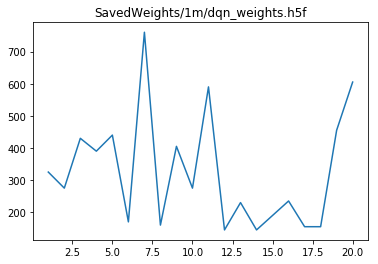

In [23]:
import matplotlib.pyplot as plt

x = np.arange(1, episode + 1)
y = scores.history['episode_reward']

plt.plot(x, y)
plt.title(pre_trained_model)
plt.show()